# Mã hoá số nguyên với các non_req vertex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import time


In [2]:
N = None # number of vertices
E = [] # contains edge
k = None # number of clusters
clusters = [] # contains vertiecs of each cluster
a = [] # contain weight matrix
non_req = None # number of non_req vertices
mapping_non_req = {} # used for mapping each element of chromosome to each non_req vertex

In [3]:
def check_exist(arr, element):
    return any(element in row for row in arr)

def read_data(dist):
    global N, E, clusters, k, a, non_req, mapping_non_req
    N = None
    E = []
    a = []
    clusters = []
    k = None
    non_req = None
    mapping_non_req = {}
    with open(dist, 'r', encoding='utf-8') as f:
        print(f.readline())
        print(f.readline())
        N = int(f.readline().split(' ')[2])
        k = int(f.readline().split(' ')[1])
        non_req = N
        print(f.readline())
        # print(f.readline())

        for i in range(N):
            tmp = f.readline().split()
            # print(tmp)
            for j in range(i+1, N):
                E.append([i, j, int(tmp[j])])
            
            a.append([])
            for j in range(N):
                a[i].append(int(tmp[j]))

        print(f.readline())
        # print(f.readline())
        for i in range(k):
            tmp = f.readline().split()
            tmp2 = []
            for j in range(1, len(tmp)-1):
                tmp2.append(int(tmp[j])-1)
                non_req -= 1
            clusters.append(tmp2)
        
        cnt = 0
        for i in range(N):
            if not check_exist(clusters, i):
                mapping_non_req[cnt] = i
                cnt += 1

        print(clusters)
        # print(non_req)
        # print(mapping_non_req)
        


In [4]:
class Chromosome:
    # n la so đỉnh free
    # k la sô cụm
    def __init__(self, non_req, k, arr = None):
        if arr is None:
            arr = np.random.randint(0, k, non_req)
            np.random.shuffle(arr)
            arr = arr.tolist()
        self.arr = arr
        self.fitness = -1
    
    def __call__(self):
        return self.arr
    
# test = Chromosome(non_req, k)
# print(test.arr)
    


In [5]:
def multation(chromo):
    global k, non_req
    point = np.random.randint(non_req)
    e = np.random.randint(k)
    chromo()[point] = e
    return chromo

# print(test())
# print(multation(test).arr)

In [6]:
# tạo 2 điểm cắt, đưa 2 đoạn cắt ở giữa của 2 cha cho 2 con
# phần còn lại cộng/trừ 2 vector với hệ số làm nhiễu ngẫu nhiên rồi ghép vào 2 con
def doublePointCrossover(chromo1, chromo2):
    global k
    par1_city = chromo1()
    par2_city = chromo2()

    n = len(par1_city)
    
    i1, i2 = 0, 0
    while i1>=i2:
        points = np.random.choice(range(len(par1_city) + 1), size = 2, replace=False) # lay diem cat
        i1 = points[0]
        i2 = points[1]

    # print(f'{i1} {i2}')

    child1_city = [None] * n
    child2_city = [None] * n
    child1_city[i1: i2] = par2_city[i1: i2]
    child2_city[i1: i2] = par1_city[i1: i2]
    
    remaining_par1 = np.array(par1_city[:i1] + par1_city[i2:])
    remaining_par2 = np.array(par2_city[:i1] + par2_city[i2:])

    # print(child2_city)
    # print(remaining_par1)
    e1 = np.random.randint(0, k, size = n - (i2 - i1))
    e2 = np.random.randint(0, k, size = n - (i2 - i1))
    # print(e1)
    # print(e2)
    sum_for_child1 = (remaining_par1 + remaining_par2 + e1) % k
    sum_for_child2 = (remaining_par1 - remaining_par2 + e2) % k

    child1_city[:i1], child1_city[i2:] = sum_for_child1[:i1], sum_for_child1[i1:]
    child2_city[:i1], child2_city[i2:] = sum_for_child2[:i1], sum_for_child2[i1:]
    

    new_chromo1 = Chromosome(n, k, arr = child1_city)
    new_chromo2 = Chromosome(n, k, arr = child2_city)
    return new_chromo1, new_chromo2

# test1 = Chromosome(non_req, k)
# test2 = Chromosome(non_req, k)
# print(test1())
# print(test2())
# new1, new2 = doublePointCrossover(test1, test2) 
# print(new1())
# print(new2())

In [7]:
# calculate cost of a tree of a cluster_id with some cluster_id's req vertices and some non_req vertices
def cal_inner_cluster(cx, group, non_req_list = []):
    # group is id of cluster
    # non_req_list is non_req vertices can be added to minimum tree of cluster_id
    global a
    global N
    res = 0
    Vt = []
    Et = []
    d = [1e18]*N
    p = [-1]*N
    s = cx.index(group)
    d[s] = 0
    qu = PriorityQueue()
    Vt.append(s)
    qu.put((d[s], s))

    while not qu.empty():
        du, u = qu.get()
        
        if du>d[u]:
            continue

        if cx[u] == group: # đỉnh req
            v = u
            while v not in Vt: 
                Vt.append(v)
                Et.append([p[v], v])
                d[v] = 0
                qu.put((d[v], v))
                v = p[v]
        for v in range(len(a[u])):
            if (cx[v]==-1 and v in non_req_list) or cx[v]==group:
                if d[u] + a[u][v] < d[v]:
                    d[v] = d[u] + a[u][v]
                    p[v] = u
                    qu.put((d[v], v))
    for i in Vt:
        cx[i] = group
    for u, v in Et:
        res += a[u][v]
    
    return Vt, Et, res
                

In [8]:
def cal_inter_cluster(vt):
    global N
    res = 0
    Vt = []
    Et = []
    d = [1e18]*2*N
    p = [-1]*2*N
    s = 51
    d[s] = 0
    qu = PriorityQueue()
    Vt.append(s)
    qu.put((d[s], s))

    while not qu.empty():
        du, u = qu.get()
        
        if du>d[u]:
            continue

        if u >= N: # đỉnh req
            v = u
            while v not in Vt:
                Vt.append(v)
                Et.append([p[v], v])
                res += d[v] - d[p[v]]
                d[v] = 0
                qu.put((d[v], v))
                v = p[v]

        for v, w in vt[u]:
            if d[u] + w < d[v]:
                d[v] = d[u] + w
                p[v] = u
                qu.put((d[v], v))
 
    
    return Vt, Et, res
                

In [9]:
def cal_cost(chr: Chromosome):
    if chr.fitness!= -1:
        return chr.fitness
    
    global N, E, clusters, k, a, non_req, mapping_non_req
    cost = 0 # cost of chromosome

    cx = [-1]*N # note the vertex's cluster

    for i in range(len(clusters)):
        for j in clusters[i]:
            cx[j] = i

    # print(cx)
    # prim + dijsktra on each cluster
    non_req_list = [[] for i in range(k)]
    for i in range(len(chr.arr)):
        non_req_list[chr.arr[i]].append(mapping_non_req[i])
    
    # print(non_req_list)

    for i in range(k): 
        _, _, tmp_cost = cal_inner_cluster(cx, i, non_req_list=non_req_list[i])
        cost += tmp_cost

    # print(cx)
    
    # contract thành một danh sách cạnh
    dict = {}
    for edge in E:
        u = edge[0]
        v = edge[1]
        w = edge[2]
        if cx[u] != -1:
            u = cx[u] + N
        if cx[v] != -1:
            v = cx[v] + N
        if u==v:
            continue

        # tạo edge và đỉnh kề cho từng đỉnh
        if u > v:
            u, v = v, u
        
        if (u, v) not in dict:
            dict[(u, v)] = w
        else:
            dict[(u, v)] = min(w, dict[(u, v)])

    # tạo danh sách cạnh kề
    vt = [[] for i in range(2*N)] 
    for key, item in dict.items():
        u = key[0]
        v = key[1]
        vt[u].append((v, item))
        vt[v].append((u, item))
        
    _ , _, inter_cost = cal_inter_cluster(vt)
    cost += inter_cost
    chr.fitness = cost
    return cost

# [[14, 26, 30, 37, 43, 48], [8, 20, 32, 33, 36, 46], [5, 11, 16, 18, 23, 27, 28, 38], [4, 22, 25, 29, 31, 34, 42, 44], [6, 9, 17, 19, 24, 35, 39, 40, 47, 49, 50]]
# print(cal_cost(test))
# print(test())

In [10]:
def generate_chromosome(num):
    population = []
    global k
    for i in range(num):
        population.append(Chromosome(non_req, k))
    
    for i in range(len(population)):
        cal_cost(population[i])
    return population


In [11]:
def choose_best(parent_pop, children_pop):
    n = len(parent_pop)
    mixed_pop = parent_pop + children_pop
    for i in range(len(children_pop)):
        cal_cost(children_pop[i])
    for i in range(len(parent_pop)):   
        cal_cost(parent_pop[i])
        
    mixed_pop = sorted(mixed_pop, key = lambda x: x.fitness)
    return mixed_pop[:n]

In [12]:
def cross_over_population(num_pop, parent_pop, multation_rate = 0.2, rate = 0.1):
    for i in range(len(parent_pop)):
        cal_cost(parent_pop[i])
    child_pop = []
    num_to_rand = int(num_pop*rate) # số lượng lấy sample
    for i in range(num_pop):
        tmp_par = np.random.choice(parent_pop, size=num_to_rand, replace=False)
        tmp_par = sorted(tmp_par, key = lambda x: x.fitness)
        parent1, parent2 = tmp_par[0: 2]
        child1, child2 = doublePointCrossover(parent1, parent2)
        random_value = np.random.rand()
        if random_value <= multation_rate:
            child1 = multation(child1)
            child2 = multation(child2)
        
        child_pop.append(child1)
        child_pop.append(child2)
    return child_pop

In [13]:
# calculate cost for 1 population after some generation with 1 certain seed
def main(num_pop = 100, num_gen = 500, mutation_rate = 0.2, seed = 42, plot=False):
    np.random.seed(seed=seed)
    global N
    best_chr = []
    population = generate_chromosome(num_pop)
    for gen in range(num_gen):
        child_pop = cross_over_population(num_pop, population, multation_rate=mutation_rate, rate=0.1)
        population = choose_best(parent_pop=population, children_pop=child_pop)
        # print(f'gen {gen}: {population[0].fitness}, {population[0].arr[:10]},\n {child_pop[0].fitness}, {child_pop[0].arr[:10]}')
        best_chr.append(population[0].fitness)
    # print(f'seed: {seed}, result = {population[0].fitness}, {population[0].arr[:-5]}')
    if plot:
        indices = range(0, num_gen)
        plt.plot(indices, best_chr)
        plt.text(indices[-1], best_chr[-1], str(best_chr[-1]), ha='right', va='bottom')
        # Đặt nhãn cho trục x và trục y
        plt.xlabel('Best_Fitness')
        plt.ylabel('No generation')
        plt.show()
        
    return population[0].fitness


Name : 10berlin52

TYPE: NON_EUC_CLUSTERED_TREE

EDGE_WEIGHT_SECTION:

CLUSTER_SECTION:

[[0], [12, 27, 51], [1], [15, 19], [3, 39, 45], [8], [32], [7, 44], [10, 11], [2]]


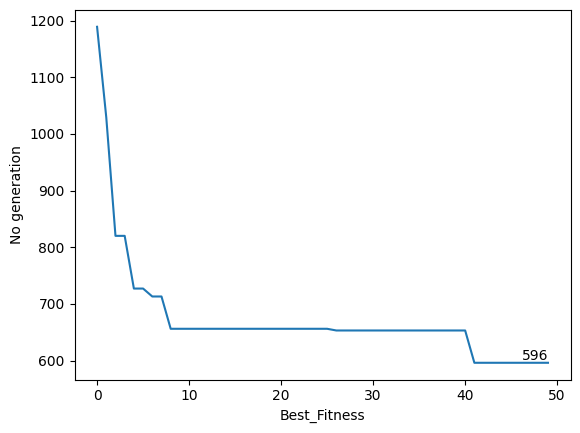

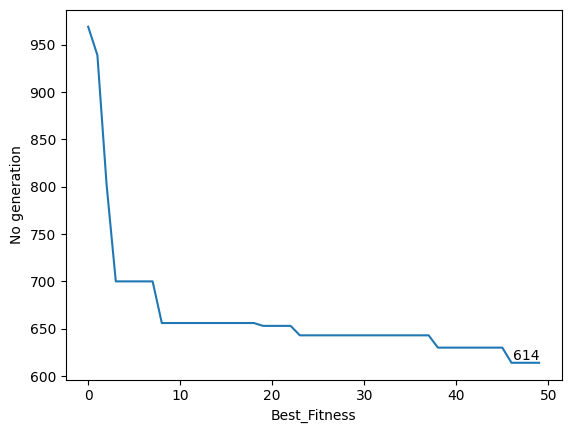

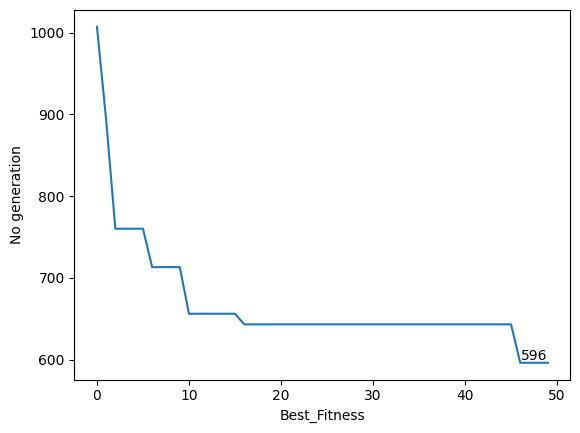

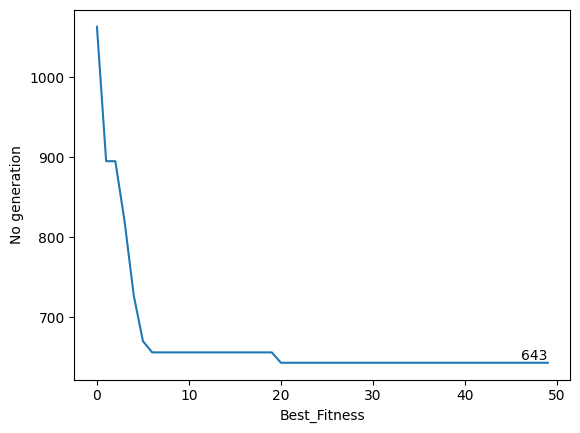

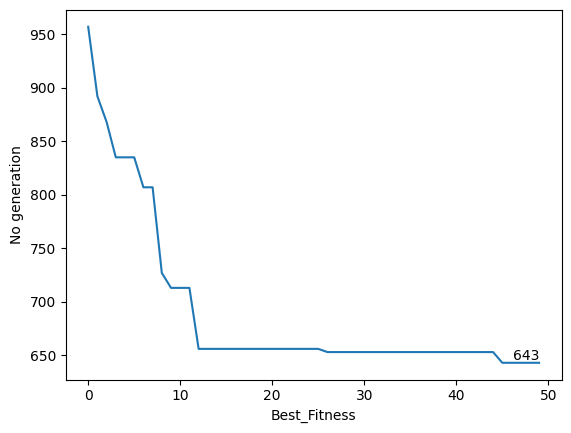

Over 30 seeds, avg_fitness: 618.4, best_fitness: 596, time(s): 144.006


618.4

In [14]:
# calculate cost for multi_seed (eg: from 1 to 30)
def cost_avg(seeds = 30, plot = True):
    start_time = time.time()
    avg_fitness = 0
    best_fitness = 1e19
    for i in range(seeds):
        tmp_fitness = main(num_pop=200, num_gen=50, mutation_rate=0.2, seed=i, plot=plot)
        best_fitness = min(best_fitness, tmp_fitness)
        avg_fitness += tmp_fitness
    avg_fitness /= seeds
    end_time = time.time()
    execution_time = round(end_time - start_time, 3)
    print(f'Over 30 seeds, avg_fitness: {avg_fitness}, best_fitness: {best_fitness}, time(s): {execution_time}')
    
    return avg_fitness

read_data(r'Data\Type_1_Small\10berlin52.txt')
cost_avg(seeds=5)

In [15]:
# benchmark over some small data
file_list = [
  '10berlin52.txt',
# '10kroB100.txt',
# '10pr76.txt',
# '10rat99.txt',
# '10st70.txt',
# '50lin105.txt',
# '50rat99.txt',
# '5berlin52.txt',
# '5eil51.txt',
# '5eil76.txt',
# '5pr76.txt',
# '5st70.txt',
# '75lin105.txt'
]
for file in file_list:
    read_data(fr'Data\Type_1_Small\{file}') 
    cost_avg(plot = False)

Name : 10berlin52

TYPE: NON_EUC_CLUSTERED_TREE

EDGE_WEIGHT_SECTION:

CLUSTER_SECTION:

[[0], [12, 27, 51], [1], [15, 19], [3, 39, 45], [8], [32], [7, 44], [10, 11], [2]]
Over 30 seeds, avg_fitness: 599.8666666666667, best_fitness: 567, time(s): 851.438
